In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StringType, StructType, StructField, TimestampType, IntegerType
from pyspark.sql.functions import from_json, col

# Define the path to the jars on the EC2 instance
spark_jars_path = "/home/ec2-user/stream-processing-template/jars"  # <-- Update this path

spark = SparkSession.builder.appName("retail_pysaprk_consumer") \
    .config("spark.jars", f"{spark_jars_path}/commons-pool2-2.11.1.jar,"
            f"{spark_jars_path}/spark-sql-kafka-0-10_2.12-3.4.0.jar,"
            f"{spark_jars_path}/spark-streaming-kafka-0-10-assembly_2.12-3.4.0.jar") \
    .getOrCreate()

23/12/13 15:48:01 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
/usr/local/lib/python3.7/site-packages/pyspark/context.py:317: FutureWarning: Python 3.7 support is deprecated in Spark 3.4.
  warnings.warn("Python 3.7 support is deprecated in Spark 3.4.", FutureWarning)


In [2]:
import time
# Define the schema for our data
schema = StructType([
    StructField("store_location", StringType(), True),
    StructField("time_of_purchase", TimestampType(), True),
    StructField("product_ID", StringType(), True),
    StructField("transaction_amount", IntegerType(), True)
])

# Stream from Kafka topic
df = spark.readStream \
    .format("kafka") \
    .option("kafka.bootstrap.servers", "b-1.monstercluster1.6xql65.c3.kafka.eu-west-2.amazonaws.com:9092") \
    .option("subscribe", "retail_transactions") \
    .load()

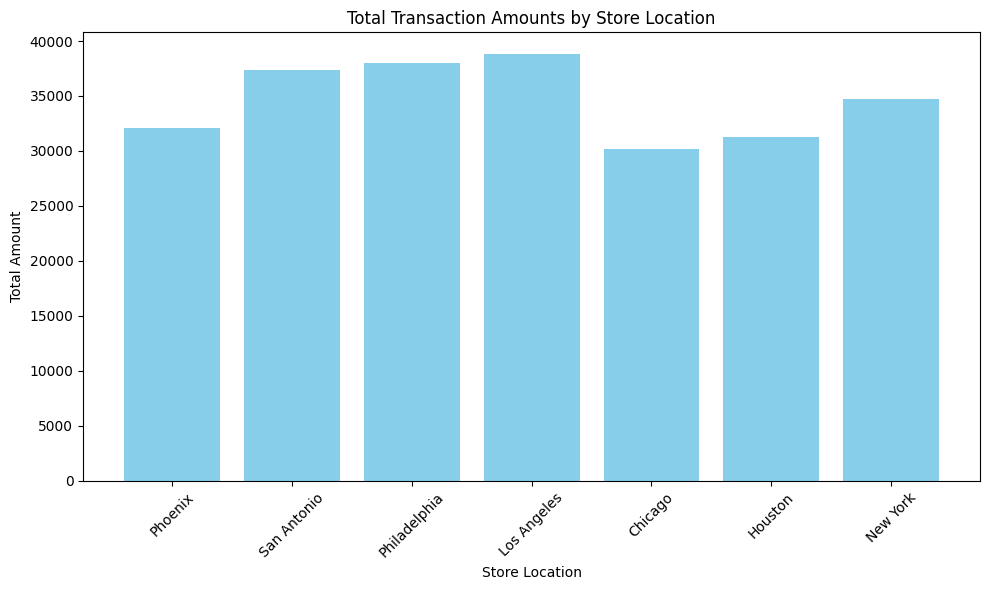

KeyboardInterrupt: 

In [7]:
import time
import matplotlib.pyplot as plt
from IPython import display
from pyspark.sql.functions import from_json, col, sum

transactions = (df.selectExpr("CAST(value AS STRING)")
                .withColumn("data", from_json(col("value"), schema))
                .select("data.*"))

# This assumes you've set up a Spark streaming query that's writing aggregated results to an in-memory table.
# Here's a simple example of how you'd do that with your data (this part isn't in the loop):
query = transactions.groupBy("store_location").agg(sum("transaction_amount").alias("total_amount")) \
    .writeStream \
    .outputMode("complete") \
    .format("memory") \
    .queryName("electric_boogaloo") \
    .start()

# Now, for the dynamic visualization:
while True:
    # Clear the previous plot
    display.clear_output(wait=True)
    
    # Get the latest aggregated data
    agg_by_location_pd = spark.sql("SELECT * FROM electric_boogaloo").toPandas()
    
    # Plotting
    plt.figure(figsize=(10, 6))
    plt.bar(agg_by_location_pd['store_location'], agg_by_location_pd['total_amount'], color='skyblue')
    plt.title('Total Transaction Amounts by Store Location')
    plt.xlabel('Store Location')
    plt.ylabel('Total Amount')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    time.sleep(5)  # Refresh every 10 seconds. Adjust this to your needs.